In [1]:
import os
import json
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

# Fetch results

In [8]:
models = ["CNN", "UNet"]
optimizers = ["adam", "sgd"]
loss_functions = ["bce_loss", "dice_loss", "focal_loss", "bce_total_variation"]

In [9]:
# Create empty dictionaries for stats and test metrics
all_stats = {}
all_test_metrics = {}

In [10]:
# Loop over the models
for model in models:
    # Loop over the optimizers
    for optimizer in optimizers:
        # Loop over the loss functions
        for loss_function in loss_functions:
            # Define the model name based on the configuration
            model_name = f"{model.lower()}_16_{optimizer}_{loss_function}_augmented"

            # Load the stats JSON file
            stats_path = f"models/{model.lower()}/stats/{model_name}.json"
            with open(stats_path, "r") as f:
                all_stats[model_name] = json.load(f)

            # Load the test metrics JSON file
            test_metrics_path = f"models/{model.lower()}/stats/{model_name}_test_metrics.json"
            with open(test_metrics_path, "r") as f:
                all_test_metrics[model_name] = json.load(f)

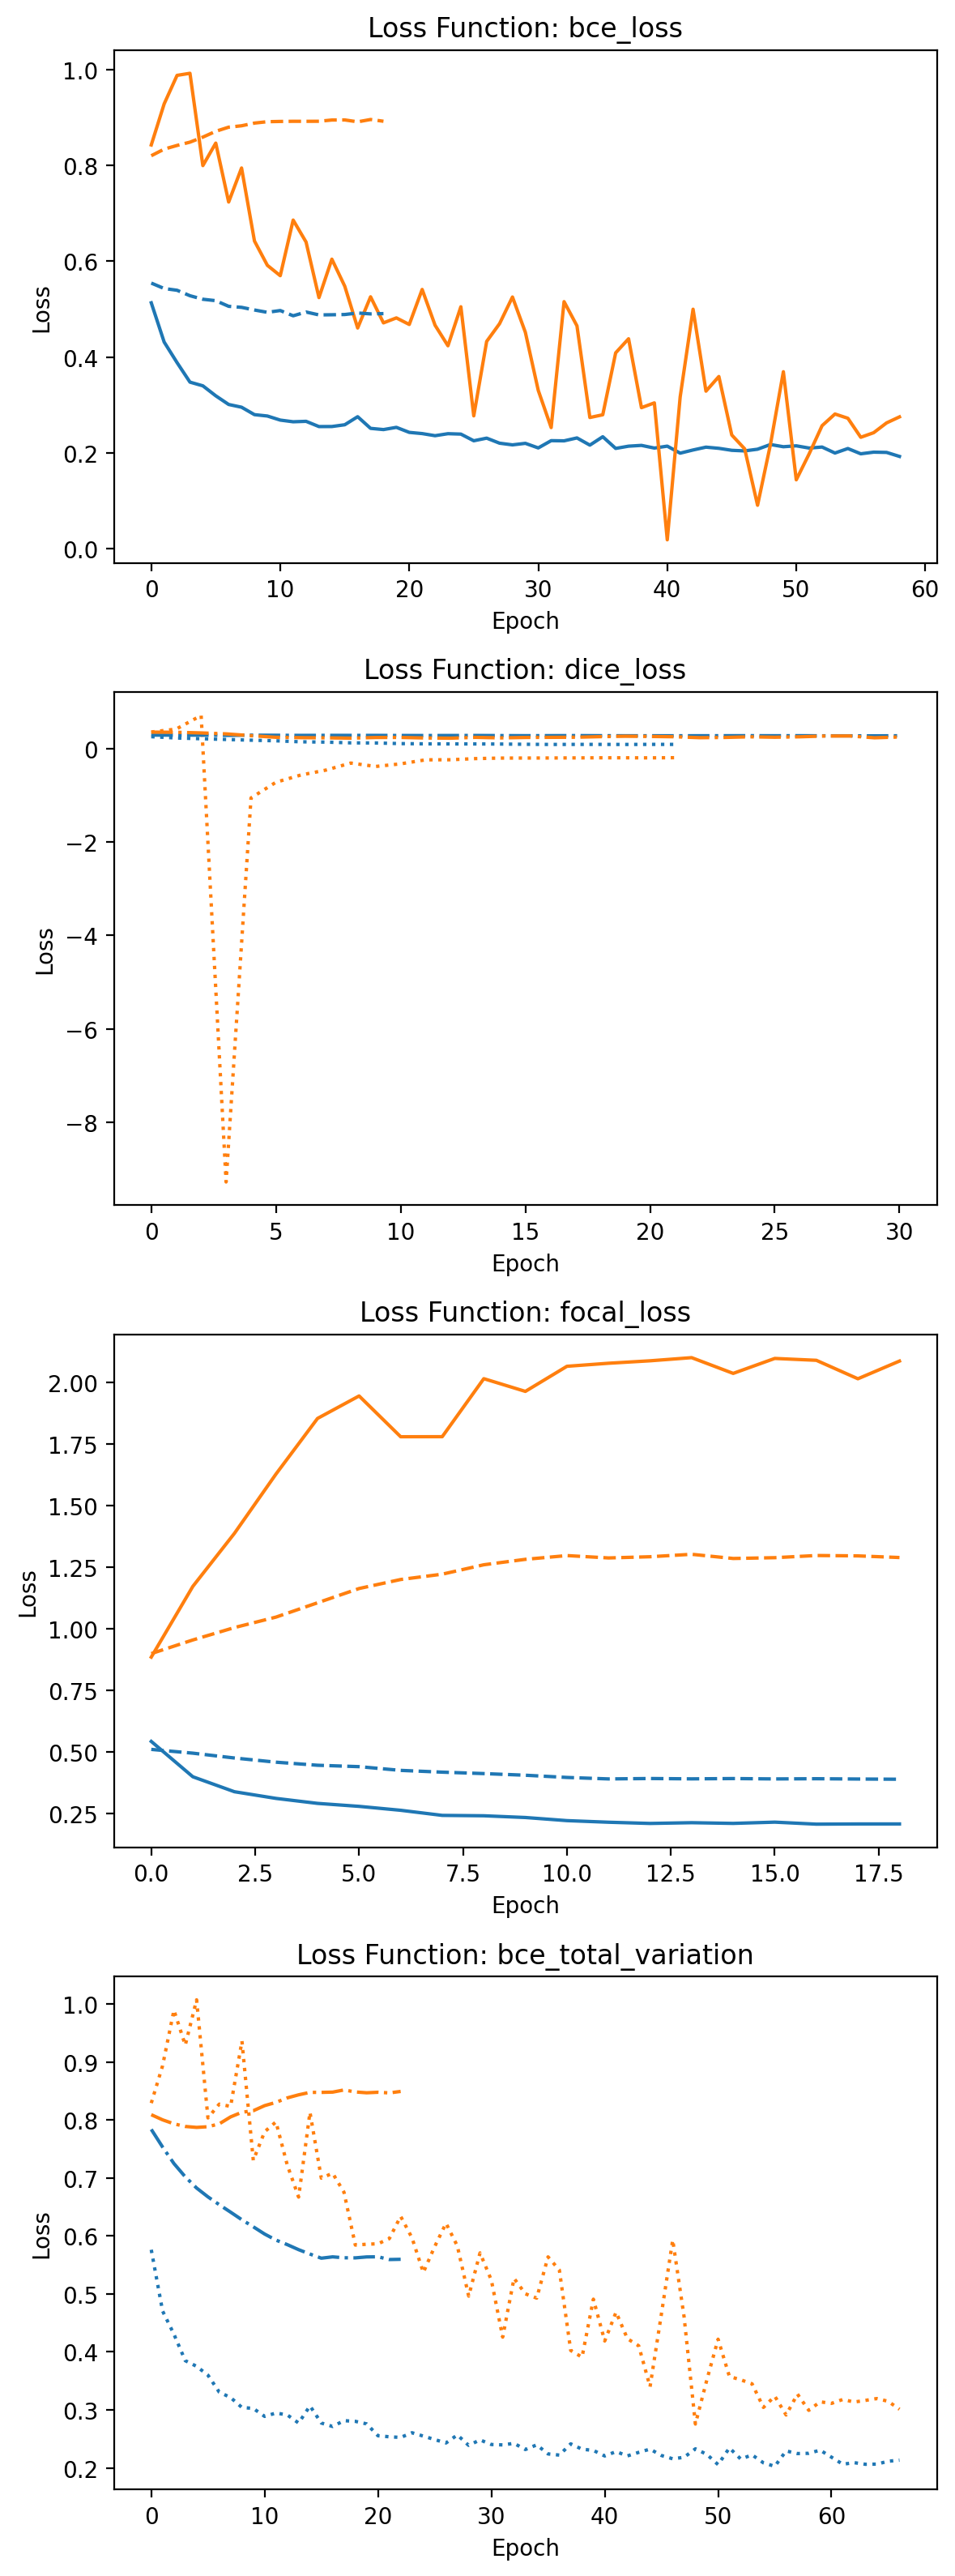

In [13]:
fig, axs = plt.subplots(len(loss_functions), 1, figsize=(6, 4*len(loss_functions)), tight_layout=True, dpi=200)

max_epoch = 0
linestyles = ['-', '--', ':', '-.']
linestyle_idx = 0

for i, loss_function in enumerate(loss_functions):
    loss_function_models = [model_name for model_name in all_stats.keys() if loss_function in model_name]
    ax = axs[i]
    for model_name in loss_function_models:
        linestyle = linestyles[linestyle_idx % len(linestyles)]
        plot_learning_curves(all_stats[model_name], model_name, ax, linestyle)
        linestyle_idx += 1
        max_epoch = max(len(all_stats[model_name]["train_loss"]), len(all_stats[model_name]["val_loss"]), max_epoch)

    ax.set_title(f"Loss Function: {loss_function}")

# Learning curves (UNet)

In [5]:
c1, c2 = plt.rcParams['axes.prop_cycle'].by_key()['color'][:2]

In [6]:
def plot_learning_curves(stats, model_name, ax, linestyle):
    train_loss = stats["train_loss"]
    val_loss = stats["val_loss"]
    ax.plot(train_loss, c=c1, ls=linestyle, label='train')
    ax.plot(val_loss, c=c2, ls=linestyle, label='validation')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')

# Test metrics (UNet)

In [26]:
import pandas as pd

# Define the models and scores
models = list(all_test_metrics.keys())

# Define the scores to include in the table
scores = list(all_test_metrics[models[0]].keys())

# Create abbreviations for the model names
model_abbreviations = {
    'cnn_16_adam_bce_loss_augmented': 'CNN-AL',
    'cnn_16_adam_dice_loss_augmented': 'CNN-AD',
    'cnn_16_adam_focal_loss_augmented': 'CNN-AF',
    'cnn_16_adam_bce_total_variation_augmented': 'CNN-AV',
    'cnn_16_sgd_bce_loss_augmented': 'CNN-SL',
    'cnn_16_sgd_dice_loss_augmented': 'CNN-SD',
    'cnn_16_sgd_focal_loss_augmented': 'CNN-SF',
    'cnn_16_sgd_bce_total_variation_augmented': 'CNN-SV',
    'unet_16_adam_bce_loss_augmented': 'UNet-AL',
    'unet_16_adam_dice_loss_augmented': 'UNet-AD',
    'unet_16_adam_focal_loss_augmented': 'UNet-AF',
    'unet_16_adam_bce_total_variation_augmented': 'UNet-AV',
    'unet_16_sgd_bce_loss_augmented': 'UNet-SL',
    'unet_16_sgd_dice_loss_augmented': 'UNet-SD',
    'unet_16_sgd_focal_loss_augmented': 'UNet-SF',
    'unet_16_sgd_bce_total_variation_augmented': 'UNet-SV'
}

# Create a dataframe for the table
table_data = []
for model in models:
    abbreviation = model_abbreviations.get(model, model)
    row = [abbreviation]
    for score in scores:
        mean = all_test_metrics[model][score]['mean']
        conf_interval = all_test_metrics[model][score]['conf_interval']
        row.extend([f"{mean:.4f} ± {conf_interval:.4f}"])
    table_data.append(row)

columns = ['Model']
for score in scores:
    columns.append(score)

df = pd.DataFrame(table_data, columns=columns)

# Convert to LaTeX table format
latex_table = df.to_latex(index=False)

# Print the LaTeX table
print(latex_table)

\begin{tabular}{llllll}
\toprule
Model & jaccard & dice & accuracy & precision & recall \\
\midrule
CNN-AL & 0.6730 ± 0.0172 & 0.8044 ± 0.0123 & 0.8044 ± 0.0123 & 0.0000 ± 0.0000 & 0.0000 ± 0.0000 \\
CNN-AD & 0.6730 ± 0.0172 & 0.8044 ± 0.0123 & 0.8044 ± 0.0123 & 0.0000 ± 0.0000 & 0.0000 ± 0.0000 \\
CNN-AF & 0.6730 ± 0.0172 & 0.8044 ± 0.0123 & 0.8044 ± 0.0123 & 0.0000 ± 0.0000 & 0.0000 ± 0.0000 \\
CNN-AV & 0.6730 ± 0.0172 & 0.8044 ± 0.0123 & 0.8044 ± 0.0123 & 0.0000 ± 0.0000 & 0.0000 ± 0.0000 \\
CNN-SL & 0.6730 ± 0.0172 & 0.8044 ± 0.0123 & 0.8044 ± 0.0123 & 0.0000 ± 0.0000 & 0.0000 ± 0.0000 \\
CNN-SD & 0.1084 ± 0.0075 & 0.1956 ± 0.0123 & 0.1956 ± 0.0123 & 0.1956 ± 0.0123 & 1.0000 ± 0.0000 \\
CNN-SF & 0.6730 ± 0.0172 & 0.8044 ± 0.0123 & 0.8044 ± 0.0123 & 0.0000 ± 0.0000 & 0.0000 ± 0.0000 \\
CNN-SV & 0.6730 ± 0.0172 & 0.8044 ± 0.0123 & 0.8044 ± 0.0123 & 0.0000 ± 0.0000 & 0.0000 ± 0.0000 \\
UNet-AL & 0.8855 ± 0.0028 & 0.9393 ± 0.0016 & 0.9393 ± 0.0016 & 0.8613 ± 0.0087 & 0.8213 ± 0.0023 \\

In [27]:
abbreviation_descriptions = {
    'AL': 'Adam optimizer with Binary Cross-Entropy (BCE) loss',
    'AD': 'Adam optimizer with Dice loss',
    'AF': 'Adam optimizer with Focal loss',
    'AV': 'Adam optimizer with BCE and Total Variation (TV) loss',
    'SL': 'SGD optimizer with BCE loss',
    'SD': 'SGD optimizer with Dice loss',
    'SF': 'SGD optimizer with Focal loss',
    'SV': 'SGD optimizer with BCE and Total Variation (TV) loss'
}

# Print the abbreviation explanations
for abbreviation, explanation in abbreviation_descriptions.items():
    print(f"{abbreviation}: {explanation}")


AL: Adam optimizer with Binary Cross-Entropy (BCE) loss
AD: Adam optimizer with Dice loss
AF: Adam optimizer with Focal loss
AV: Adam optimizer with BCE and Total Variation (TV) loss
SL: SGD optimizer with BCE loss
SD: SGD optimizer with Dice loss
SF: SGD optimizer with Focal loss
SV: SGD optimizer with BCE and Total Variation (TV) loss
